In [1]:
# 20210424 해커톤 윤요섭

In [2]:
# 780,502개의 정보를 5914명의 고객별로 분류해서 각 인원이
#한 달에 평균적으로 300을 넘게
# 쓰는지, 안 쓰는 지 분류
# 의사결정트리, 랜덤포레스트, 부스팅 계열을 통해 모델을
# 학습 시켜서, 확인해볼 예정

# 랜덤으로 추출해서 랜덤포레스트에 돌렸을 때,
# 의사결정트리가 첫 번째로 year_month에 따라 24개의 달로 분류한 후에
# 랜덤으로 추출된 각 달에 인원들이 각 의사결정트리에 따라 300이 넘는지
# 그렇지 않은지 분류해서 카운트

# 배깅을 통해 각 인원들이 300을 넘게 썻는지 확인
# 배깅의 단점을 보완하기 위해 부스팅 계열 사용

# 한 고객이 월 평균 300을 실제로 넘겼는데, 예측에서 300을 넘기지 못했다고
# 판단하는 오류(FNR: FN/TP+FN), 한 고객이 월 평균을 300을 실제로 넘기지
# 못했는데, 넘겼다고 판단해버리는 오류(FPR: FP/FP+TN)를 방지하기 위해
#  Accuracy를 확인 (TP+TN/TP+TN+FP+FN)

In [3]:
# 도구 불러오기
import graphviz
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
from sklearn import tree
import mglearn
import os
from sklearn import preprocessing
import seaborn as sns0
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from collections import Counter
from sklearn.metrics import classification_report
import statsmodels as sm
import sklearn 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import datasets
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from lightgbm import plot_importance
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
%matplotlib inline

In [4]:
# 파일 불러오기
train=pd.read_csv('C:/Users/bella/Desktop/train.csv')
sample_submission=pd.read_csv('C:/Users/bella/Desktop/sample_submission.csv')

In [5]:
# 데이터 프레임으로 변환
df_train=pd.DataFrame(train)
df_sample_submission=pd.DataFrame(sample_submission)

In [6]:
df_train.describe()

,quantity,price,customer_id,total
count,780502.000000,780502.000000,780502.000000,780502.000000
mean,12.623307,6.140931,15313.393466,33.715373
std,143.906302,119.042266,1695.765797,274.207403
min,-74215.000000,0.000000,12346.000000,-127352.940000
25%,2.000000,2.062500,13963.000000,7.260000
50%,5.000000,3.217500,15239.000000,19.470000
75%,12.000000,6.187500,16788.000000,32.175000
max,74215.000000,64300.500000,18287.000000,127352.940000


In [7]:
df_train.head()

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,11.4675,13085,United Kingdom,137.61
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,3.4650,13085,United Kingdom,166.32
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,2.0625,13085,United Kingdom,49.50


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780502 entries, 0 to 780501
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   order_id     780502 non-null  object 
 1   product_id   780502 non-null  object 
 2   description  780502 non-null  object 
 3   quantity     780502 non-null  int64  
 4   order_date   780502 non-null  object 
 5   price        780502 non-null  float64
 6   customer_id  780502 non-null  int64  
 7   country      780502 non-null  object 
 8   total        780502 non-null  float64
dtypes: float64(2), int64(2), object(5)
memory usage: 53.6+ MB


In [9]:
# label encoding
from sklearn import preprocessing

le=preprocessing.LabelEncoder()

df_train_encoded_order_id=le.fit_transform(df_train['order_id'])
np_order_id=df_train_encoded_order_id.reshape(-1,1)
order_id_1=map(lambda x: x[0], np_order_id)
order_id=pd.Series(order_id_1)
type(order_id)

df_train_encoded_product_id=le.fit_transform(df_train['product_id'])
np_product_id=df_train_encoded_product_id.reshape(-1,1)
product_id_1=map(lambda x: x[0], np_product_id)
product_id=pd.Series(product_id_1)
type(product_id)

df_train_encoded_description=le.fit_transform(df_train['description'])
np_description=df_train_encoded_description.reshape(-1,1)
description_1=map(lambda x: x[0], np_description)
description=pd.Series(description_1)
type(description)

df_train_encoded_country=le.fit_transform(df_train['country'])
np_country=df_train_encoded_country.reshape(-1,1)
country_1=map(lambda x: x[0], np_country)
country=pd.Series(country_1)
type(country)

pandas.core.series.Series

In [10]:
# datetime의 type을 datetime64[ns]으로 변환
import datetime
order_date_1=pd.to_datetime(df_train['order_date'])
order_date_1
type(order_date_1)
df_train['order_date']=order_date_1
df_train['order_date']

0        2009-12-01 07:45:00
1        2009-12-01 07:45:00
2        2009-12-01 07:45:00
3        2009-12-01 07:45:00
4        2009-12-01 07:45:00
                 ...        
780497   2011-11-30 17:39:00
780498   2011-11-30 17:39:00
780499   2011-11-30 17:42:00
780500   2011-11-30 17:42:00
780501   2011-11-30 17:42:00
Name: order_date, Length: 780502, dtype: datetime64[ns]

In [11]:
# datetime64[ns]에서 str로 변환 후 int로 변환
df_train['year']=df_train['order_date'].dt.year
df_train['month']=df_train['order_date'].dt.month
df_train['day']=df_train['order_date'].dt.day

year=pd.Series(df_train['year'], dtype=str)
month=pd.Series(df_train['month'], dtype=str)
day=pd.Series(df_train['day'], dtype=str)

df_train['year_month']=year+month
df_train['order_date']=year+month+day

df_train['order_date'].head()
df_train['order_date']

df_train['year']
df_train['month']
df_train['day']

order_date=pd.Series(df_train['order_date'], dtype=int)
year_month=pd.Series(df_train['year_month'], dtype=int)

#label encoding 한 값들을 각 칼럼에 대입
df_train['order_id']=order_id
df_train['product_id']=product_id
df_train['description']=description
df_train['quantity']
df_train['order_date']=order_date
df_train['price']
df_train['customer_id']
df_train['country']=country
df_train['total']
df_train['year_month']=year_month
df_train

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,year,month,day,year_month
0,0,4021,61,12,2009121,11.4675,13085,38,137.6100,2009,12,1,200912
1,0,3336,3296,12,2009121,11.1375,13085,38,133.6500,2009,12,1,200912
2,0,3338,36,12,2009121,11.1375,13085,38,133.6500,2009,12,1,200912
3,0,1261,3627,48,2009121,3.4650,13085,38,166.3200,2009,12,1,200912
4,0,620,4623,24,2009121,2.0625,13085,38,49.5000,2009,12,1,200912
...,...,...,...,...,...,...,...,...,...,...,...,...,...
780497,43953,1413,3536,-1,20111130,1.4025,15676,38,-1.4025,2011,11,30,201111
780498,43953,2312,4796,-1,20111130,5.4285,15676,38,-5.4285,2011,11,30,201111
780499,43954,3898,260,-1,20111130,2.0625,16717,38,-2.0625,2011,11,30,201111
780500,43954,4021,61,-1,20111130,13.1175,16717,38,-13.1175,2011,11,30,201111


In [12]:
# price와 total의 type을 float에서 int로 변환
price=pd.Series(df_train['price'], dtype=int)
total=pd.Series(df_train['total'], dtype=int)

df_train['price']=price
df_train['total']=total

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780502 entries, 0 to 780501
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   order_id     780502 non-null  int64
 1   product_id   780502 non-null  int64
 2   description  780502 non-null  int64
 3   quantity     780502 non-null  int64
 4   order_date   780502 non-null  int32
 5   price        780502 non-null  int32
 6   customer_id  780502 non-null  int64
 7   country      780502 non-null  int64
 8   total        780502 non-null  int32
 9   year         780502 non-null  int64
 10  month        780502 non-null  int64
 11  day          780502 non-null  int64
 12  year_month   780502 non-null  int32
dtypes: int32(4), int64(9)
memory usage: 65.5 MB


In [13]:
df_train.head()

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,year,month,day,year_month
0,0,4021,61,12,2009121,11,13085,38,137,2009,12,1,200912
1,0,3336,3296,12,2009121,11,13085,38,133,2009,12,1,200912
2,0,3338,36,12,2009121,11,13085,38,133,2009,12,1,200912
3,0,1261,3627,48,2009121,3,13085,38,166,2009,12,1,200912
4,0,620,4623,24,2009121,2,13085,38,49,2009,12,1,200912


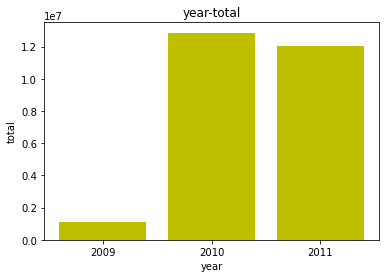

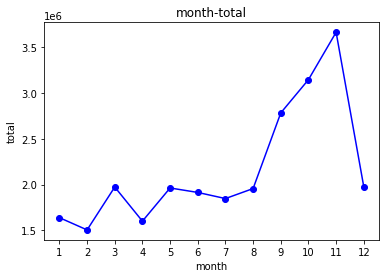

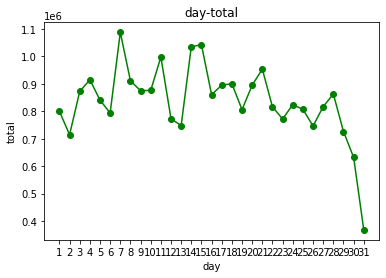

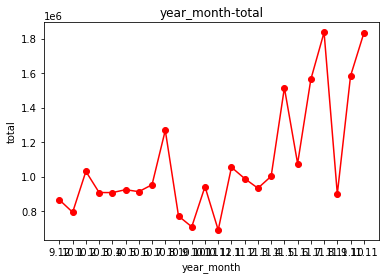

In [14]:
# 년 별 매출
from matplotlib import pyplot as plt
df_train.year

df_train['year'].unique()
year_total=df_train.groupby('year')['total'].sum()
year_total

labels=['2009','2010','2011']


fig, ax=plt.subplots()
ax.bar(labels, year_total, color='y')
plt.xlabel("year")
plt.ylabel("total")
plt.title("year-total")
plt.show()


# 월 별로 매출을 봐보자. 어느 달에 가장 많이 팔렸을까?
df_train['month'].unique()
month_total=df_train.groupby('month')['total'].sum()
month_total

labels=['1','2','3','4','5','6','7','8','9','10','11','12']


fig, ax=plt.subplots()
plt.plot(labels, month_total, marker="o", color='b')
plt.xlabel("month")
plt.ylabel("total")
plt.title("month-total")
plt.show()
# 11월이 가장 많이 팔림 #2월이 가장 안 팔림

# 일 별로 매출을 보자.
df_train['day'].unique()
day_total=df_train.groupby('day')['total'].sum()
day_total

labels=['1','2','3','4','5','6','7','8','9','10','11','12','13',
'14','15','16','17','18','19','20','21','22','23','24','25','26',
'27','28','29','30','31']

fig, ax=plt.subplots()
plt.plot(labels, day_total, marker="o", color='g')
plt.xlabel("day")
plt.ylabel("total")
plt.title("day-total")
plt.show()

# 2009.11월부터 2011년 11월까지 월별 순서대로 매출
df_train['year_month'].unique()
year_month_total=df_train.groupby('year_month')['total'].sum()
year_month_total

labels=['9.12','10.1','10.2','10.3','10.4','10.5','10.6','10.7','10.8','10.9','10.10','10.11','10.12',
'11.1','11.2','11.3','11.4','11.5','11.6','11.7','11.8','11.9','11.10','11.11']

fig, ax=plt.subplots()
plt.plot(labels, year_month_total, marker="o", color='r')
plt.xlabel("year_month")
plt.ylabel("total")
plt.title("year_month-total")
plt.show()

In [15]:
# 임의로 만들었던 year, month, day 제거
df_train=df_train.drop(['year'], axis=1)
df_train=df_train.drop(['month'], axis=1)
df_train=df_train.drop(['day'], axis=1)
#df_train=df_train.drop(['order_date'], axis=1)
df_train=df_train.drop(['description'], axis=1)
df_train

,order_id,product_id,quantity,order_date,price,customer_id,country,total,year_month
0,0,4021,12,2009121,11,13085,38,137,200912
1,0,3336,12,2009121,11,13085,38,133,200912
2,0,3338,12,2009121,11,13085,38,133,200912
3,0,1261,48,2009121,3,13085,38,166,200912
4,0,620,24,2009121,2,13085,38,49,200912
...,...,...,...,...,...,...,...,...,...
780497,43953,1413,-1,20111130,1,15676,38,-1,201111
780498,43953,2312,-1,20111130,5,15676,38,-5,201111
780499,43954,3898,-1,20111130,2,16717,38,-2,201111
780500,43954,4021,-1,20111130,13,16717,38,-13,201111


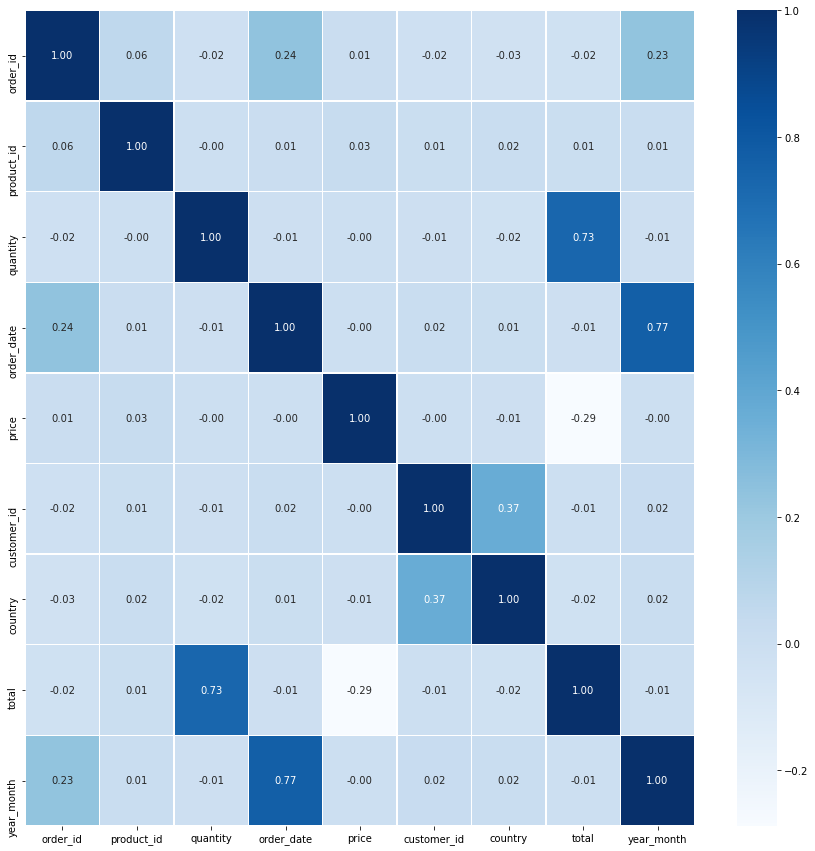

In [16]:
# 상관관계 시각화
# 히트맵
import seaborn as sns

df_train.corr()
plt.figure(figsize=(15,15))
sns.heatmap(data=df_train.corr(), annot=True, fmt ='.2f', linewidths=.5, cmap='Blues')
plt.show()

[700309, 80185]


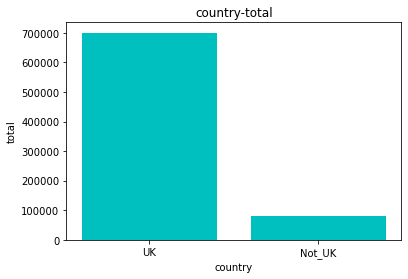

In [17]:
# 국가에 따른 특성
UK=len(df_train[df_train['country']==38].value_counts()) #700308 명
Not_UK=len(df_train[df_train['country']!=38].value_counts()) #56,491명

country=[UK, Not_UK]
print(country)
labels=['UK','Not_UK']

fig, ax=plt.subplots()
ax.bar(labels, country, color='c')
plt.xlabel("country")
plt.ylabel("total")
plt.title("country-total")
plt.show()

In [18]:
df_train

,order_id,product_id,quantity,order_date,price,customer_id,country,total,year_month
0,0,4021,12,2009121,11,13085,38,137,200912
1,0,3336,12,2009121,11,13085,38,133,200912
2,0,3338,12,2009121,11,13085,38,133,200912
3,0,1261,48,2009121,3,13085,38,166,200912
4,0,620,24,2009121,2,13085,38,49,200912
...,...,...,...,...,...,...,...,...,...
780497,43953,1413,-1,20111130,1,15676,38,-1,201111
780498,43953,2312,-1,20111130,5,15676,38,-5,201111
780499,43954,3898,-1,20111130,2,16717,38,-2,201111
780500,43954,4021,-1,20111130,13,16717,38,-13,201111


In [19]:
df_2=df_train.groupby(['year_month','customer_id'])['price','quantity','total'].sum().reset_index()
df_2

<ipython-input-19-c3b3aaec3348>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_2=df_train.groupby(['year_month','customer_id'])['price','quantity','total'].sum().reset_index()


,year_month,customer_id,price,quantity,total
0,20101,12346,198,19,-22
1,20101,12361,44,45,178
2,20101,12382,30,-1,-30
3,20101,12404,104,1,104
4,20101,12406,90,452,1443
...,...,...,...,...,...
26302,201111,18263,27,419,654
26303,201111,18270,28,60,278
26304,201111,18274,128,0,0
26305,201111,18276,20,-2,-20


In [20]:
customer_id_total=df_2.total

In [21]:
customer_id_total

0         -22
1         178
2         -30
3         104
4        1443
         ... 
26302     654
26303     278
26304       0
26305     -20
26306     938
Name: total, Length: 26307, dtype: int32

In [22]:
j=0

total_300=[]
for i in range(0,26307):
    if customer_id_total[j]>=300:
        total_300.append(1)
    else:
        total_300.append(0)
    j+=1

total_300=pd.Series(total_300)


In [23]:
total_300

0        0
1        0
2        0
3        0
4        1
        ..
26302    1
26303    0
26304    0
26305    0
26306    1
Length: 26307, dtype: int64

In [24]:
df_2['total_300']=total_300

In [25]:
df_2

,year_month,customer_id,price,quantity,total,total_300
0,20101,12346,198,19,-22,0
1,20101,12361,44,45,178,0
2,20101,12382,30,-1,-30,0
3,20101,12404,104,1,104,0
4,20101,12406,90,452,1443,1
...,...,...,...,...,...,...
26302,201111,18263,27,419,654,1
26303,201111,18270,28,60,278,0
26304,201111,18274,128,0,0,0
26305,201111,18276,20,-2,-20,0


(array([  34.,  114., 1887., 6495., 6953., 3637., 2188., 1317.,  830.,
         589.]),
 array([-692. , -427.6, -163.2,  101.2,  365.6,  630. ,  894.4, 1158.8,
        1423.2, 1687.6, 1952. ]),
 <BarContainer object of 10 artists>)

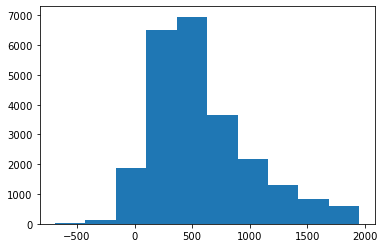

In [61]:
plt.hist(df_2['total'])

[Text(0, 0.5, 'Count'), Text(0.5, 1.0, 'total')]

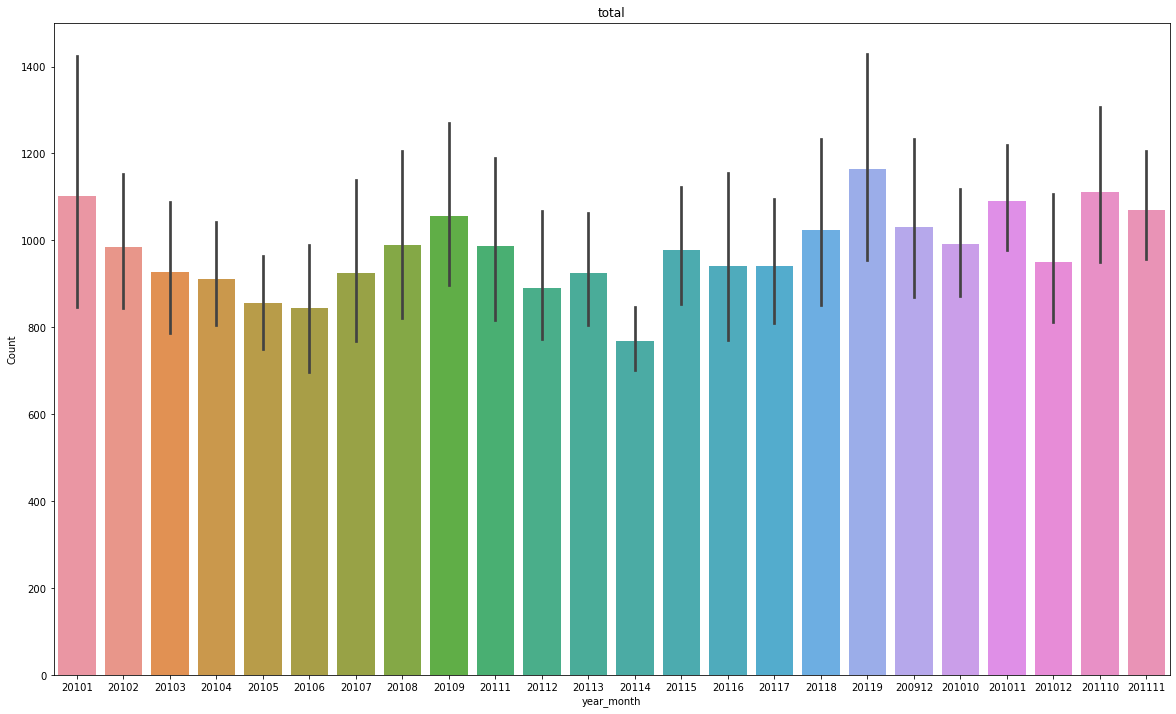

In [27]:
figure, ax2 =plt.subplots(nrows=1,ncols=1)
figure.set_size_inches(20,12)

sns.barplot(data=df_2, x="year_month", y="total", ax=ax2)

ax2.set(ylabel='Count', title="total")

[Text(0, 0.5, 'Count'), Text(0.5, 1.0, 'total')]

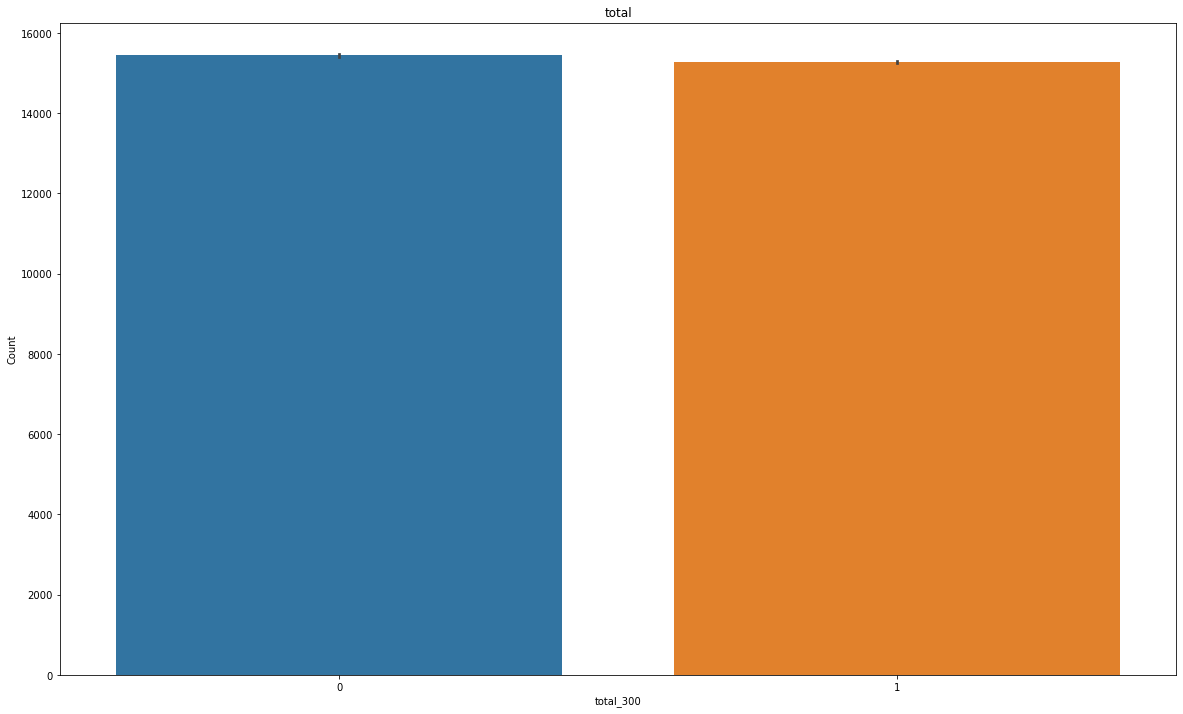

In [63]:
figure, ax3 =plt.subplots(nrows=1,ncols=1)
figure.set_size_inches(20,12)

sns.barplot(data=df_2, x="total_300", y="customer_id", ax=ax3)

ax3.set(ylabel='Count', title="total")

<AxesSubplot:xlabel='year_month', ylabel='total_300'>

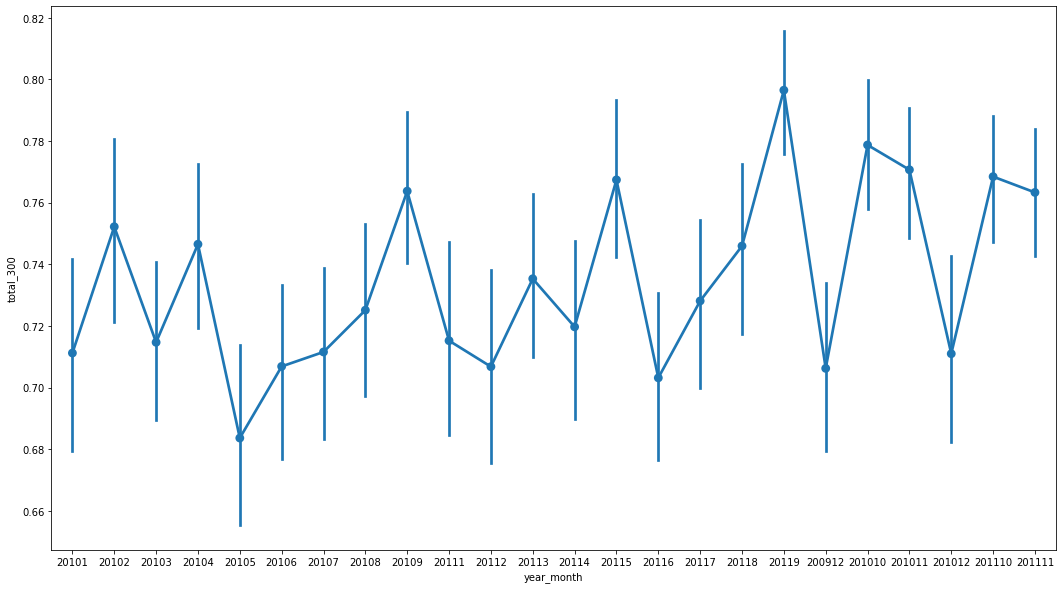

In [29]:
fig, ax1 =plt.subplots(nrows=1)
fig.set_size_inches(18,10)

sns.pointplot(data=df_2, x="year_month",y="total_300",ax=ax1)

In [30]:
# IQR
def remove_outlier_test(d_cp, column):
    fraud_column_data=d_cp[column]
    quan_25=np.percentile(fraud_column_data.values, 25)
    quan_75=np.percentile(fraud_column_data.values, 75)

    iqr=quan_75-quan_25
    iqr=iqr*1.5
    lowest=quan_25-iqr
    highest=quan_75+iqr
    outlier_index=fraud_column_data[(fraud_column_data<lowest)|(fraud_column_data>highest)].index
    print(len(outlier_index))
    d_cp.drop(outlier_index, axis=0, inplace=True)
    print(d_cp.shape)
    return d_cp

df_2=remove_outlier_test(df_2, 'total')
print(df_2)

2263
(24044, 6)
       year_month  customer_id  price  quantity  total  total_300
0           20101        12346    198        19    -22          0
1           20101        12361     44        45    178          0
2           20101        12382     30        -1    -30          0
3           20101        12404    104         1    104          0
4           20101        12406     90       452   1443          1
...           ...          ...    ...       ...    ...        ...
26302      201111        18263     27       419    654          1
26303      201111        18270     28        60    278          0
26304      201111        18274    128         0      0          0
26305      201111        18276     20        -2    -20          0
26306      201111        18283    396       435    938          1

[24044 rows x 6 columns]


In [31]:
X=df_2.drop('total_300',axis=1)
# X=X.to_numpy()
X.shape

(24044, 5)

In [32]:
y=df_2['total_300'].reindex_like(df_2.total)
# y=y.to_numpy()
y.shape

(24044,)

In [33]:
# 랜덤으로 행을 하나 추출했을 때, X는 customer_id_total를 제외한 데이터,
# y는 customer_id_total로 나누어서 학습을 시켜보자.

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.2,random_state = 42)
print(X_train)
print(X_test)
print(y_train)
print(y_test)

       year_month  customer_id  price  quantity  total
2981        20104        14006     31       760    635
10920       20113        14189     53       223    503
9270        20111        14092     80       205    515
11324       20113        16517     74        96    259
16576       20118        17988    124         8     92
...           ...          ...    ...       ...    ...
23599      201110        14099    134       379    941
5884        20107        12529      7        -2     -7
934         20102        13491     36       159    395
17172       20119        14713    121       111    327
25891      201111        16880    251       141    642

[19235 rows x 5 columns]
       year_month  customer_id  price  quantity  total
25803      201111        16560    212       325    783
15348       20117        16571     31       -36    -60
18781      200912        17290     12       123     92
7088        20108        13945    127       329    833
14246       20116        15976    190  

In [34]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(19235, 5)
(4809, 5)
(19235,)
(4809,)


In [35]:
# k-fold 

from sklearn.model_selection import cross_val_score


lr = LinearRegression()

# K-Fold cross validaition 설명 및 그림 붙이기(02/19)?
# cross_val_score( )로 5 Fold 셋으로 MSE 를 구한 뒤 이를 기반으로 다시  RMSE 구함. 
neg_mse_scores = cross_val_score(lr, X, y, scoring="neg_mean_squared_error", cv = 5)
rmse_scores  = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)


# 왜 음수로 코딩(02/19)?
# cross_val_score(scoring="neg_mean_squared_error")로 반환된 값은 모두 음수
# 회귀의 값은 작아지면 좋으니깐 마이너스를 취하면 작으면 작아지는게 좋음 (사람마다 다를듯) 
print(' 5 folds 의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 2))
print(' 5 folds 의 개별 RMSE scores : ', np.round(rmse_scores, 2))
print(' 5 folds 의 평균 RMSE : {0:.3f} '.format(avg_rmse))

 5 folds 의 개별 Negative MSE scores:  [-0.12 -0.12 -0.12 -0.12 -0.12]
 5 folds 의 개별 RMSE scores :  [0.35 0.35 0.35 0.34 0.35]
 5 folds 의 평균 RMSE : 0.346 


In [36]:
# stratify : target:
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 1.000


In [37]:
# Decision Tree
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import os

traintree = DecisionTreeClassifier(random_state=42)
traintree.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(traintree.score(X_train, y_train)))
# accuracy on training set: 1.000
print("Accuracy on test set: {:.3f}".format(traintree.score(X_test, y_test)))
# accuracy on test set: 1.000

traintree_predict=traintree.predict(X_test)

Accuracy on training set: 1.000
Accuracy on test set: 1.000


In [38]:
from sklearn.tree import export_graphviz
import graphviz

import pydotplus
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz
import graphviz

In [39]:
df_2.columns[0:4]

Index(['year_month', 'customer_id', 'price', 'quantity'], dtype='object')

In [40]:
# DecisionTreeClassifier 시각화 
from sklearn.tree import export_graphviz
import graphviz

#feature_names=df_2.columns.tolist()

feature_names=df_2.columns[0:5]
feature_names
target_name=df_2.columns[5]
target_name

dt_dot_data=tree.export_graphviz(traintree, out_file="tree.dot",
 feature_names=feature_names, class_names= target_name, filled=True, rounded= True, special_characters= True)

dt_graph = pydotplus.graph_from_dot_data(dt_dot_data)

import pydotplus
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz
import graphviz

export_graphviz(traintree, out_file="tree.dot", class_names=target_name,
                feature_names=feature_names, impurity=False, filled=True)


with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)


TypeError: object of type 'NoneType' has no len()

In [45]:
# random forest
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

traintree = DecisionTreeClassifier()
Randomforest = RandomForestClassifier(bootstrap=False)
Randomforest.fit(X_train, y_train)
traintree.fit(X_train,y_train)
y_train_pred_Deci = traintree.predict(X_train)
y_test_pred_Deci = traintree.predict(X_test)
y_train_pred = Randomforest.predict(X_train)
y_test_pred = Randomforest.predict(X_test)
print(y_train_pred_Deci)
print(y_test_pred_Deci)
print(y_train_pred)
print(y_test_pred)
print('\n')
print('MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train, y_train_pred),mean_squared_error(y_test, y_test_pred)))
print('\n')
print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred),r2_score(y_test, y_test_pred)))
print('\n')
print('MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train, y_train_pred_Deci),mean_squared_error(y_test, y_test_pred_Deci)))
print('\n')
print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred_Deci),r2_score(y_test, y_test_pred_Deci)))

[1 1 1 ... 1 1 1]
[1 0 0 ... 1 0 1]
[1 1 1 ... 1 1 1]
[1 0 0 ... 1 0 1]


MSE train: 0.000, test: 0.000


R^2 train: 1.000, test: 1.000


MSE train: 0.000, test: 0.000


R^2 train: 1.000, test: 1.000


In [46]:
#Randomforest 점수보기

Randomforest.score(X_train, y_train)

1.0

In [47]:
#Randomforest 점수보기
Randomforest.score(X_test, y_test)

1.0

In [48]:
import statsmodels.api as sm
X_constant=sm.add_constant(X)

model_1=sm.OLS(y,X_constant)
lin_reg=model_1.fit()

lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              total_300   R-squared:                       0.408
Model:                            OLS   Adj. R-squared:                  0.408
Method:                 Least Squares   F-statistic:                     3319.
Date:                Wed, 28 Apr 2021   Prob (F-statistic):               0.00
Time:                        23:33:35   Log-Likelihood:                -8619.1
No. Observations:               24044   AIC:                         1.725e+04
Df Residuals:                   24038   BIC:                         1.730e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.3240      0.021     15.572      0.000       0.283       0.365
year_month    2.12e-08   2.66e-08      0.797      0.425   -3.09e-08    7.33e-08
customer_id  2.924e-07   1.32e-06      0.222      0.824   -2.29e-06    2.88e-06
price       -1.623e-06   4.05e-06     -0.401      0.688   -9.56e-06    6.31e-06
quantity     3.077e-05   1.29e-05      2.384      0.017    5.47e-06    5.61e-05
total           0.0007   6.88e-06     95.214      0.000       0.001       0.001
==============================================================================
Omnibus:                   140727.625   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2567.555
Skew:                          -0.261   Prob(JB):                         0.00
Kurtosis:                       1.487   Cond. No.                     1.07e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.07e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [49]:
# max_depth 조절 
tree = DecisionTreeClassifier(max_depth=1, random_state=42)
tree.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 1.000


In [50]:
#Randomforest
from sklearn import metrics
confusion_matrix=metrics.confusion_matrix(y_test,y_test_pred)
print(confusion_matrix)

[[1321    0]
 [   0 3488]]


In [51]:
y_prob = Randomforest.predict_proba(X_test)[:,1] # This will give you positive class prediction probabilities  
random_y_pred = np.where(y_prob > 0.5, 1, 0) # This will threshold the probabilities to give class predictions.
Randomforest.score(X_test, random_y_pred)

1.0

In [52]:
from sklearn.metrics import roc_curve, auc
auc_roc=metrics.classification_report(y_test,random_y_pred)
print(auc_roc)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1321
           1       1.00      1.00      1.00      3488

    accuracy                           1.00      4809
   macro avg       1.00      1.00      1.00      4809
weighted avg       1.00      1.00      1.00      4809



In [53]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test.reindex, y_prob, y_test, pos_label='T')
roc_auc = auc(false_positive_rate, true_positive_rate)
print(roc_auc)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass pos_label=25803    1
15348    0
18781    0
7088     1
14246    1
        ..
23896    1
23907    1
8579     1
3819     0
7720     1
Name: total_300, Length: 4809, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


ValueError: Expected array-like (array or non-string sequence), got <bound method Series.reindex of 25803    1
15348    0
18781    0
7088     1
14246    1
        ..
23896    1
23907    1
8579     1
3819     0
7720     1
Name: total_300, Length: 4809, dtype: int64>

In [54]:
# Ada boosting 
from sklearn.ensemble import AdaBoostClassifier
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Create adaboost classifer object
abc = AdaBoostClassifier(n_estimators=100,
                         learning_rate=1,random_state = 42)
# Train Adaboost Classifer
model = abc.fit(X_train, y_train)

# Predict the response for test dataset
y_pred = model.predict(X_test)
 
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 1.0


In [55]:
# Graidient Boosting
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

gbc = GradientBoostingClassifier(random_state=42) # 기본값: max_depth=3, learning_rate=0.1

gbc.fit(X_train, y_train) 

score_train = gbc.score(X_train, y_train) # train set 정확도
print('{:.3f}'.format(score_train))

score_test = gbc.score(X_test, y_test) # 일반화 정확도
print('{:.3f}'.format(score_test))

1.000
1.000


[1]	valid_0's binary_logloss: 0.49561
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.425932
[3]	valid_0's binary_logloss: 0.370336
[4]	valid_0's binary_logloss: 0.324542
[5]	valid_0's binary_logloss: 0.286044
[6]	valid_0's binary_logloss: 0.253222
[7]	valid_0's binary_logloss: 0.224958
[8]	valid_0's binary_logloss: 0.200436
[9]	valid_0's binary_logloss: 0.179013
[10]	valid_0's binary_logloss: 0.160215
[11]	valid_0's binary_logloss: 0.143605
[12]	valid_0's binary_logloss: 0.128955
[13]	valid_0's binary_logloss: 0.115992
[14]	valid_0's binary_logloss: 0.104456
[15]	valid_0's binary_logloss: 0.0941332
[16]	valid_0's binary_logloss: 0.0849567
[17]	valid_0's binary_logloss: 0.0767679
[18]	valid_0's binary_logloss: 0.069414
[19]	valid_0's binary_logloss: 0.0628546
[20]	valid_0's binary_logloss: 0.0569492
[21]	valid_0's binary_logloss: 0.0516729
[22]	valid_0's binary_logloss: 0.0469319
[23]	valid_0's binary_logloss: 0.0426237
[24]	valid_0's binar

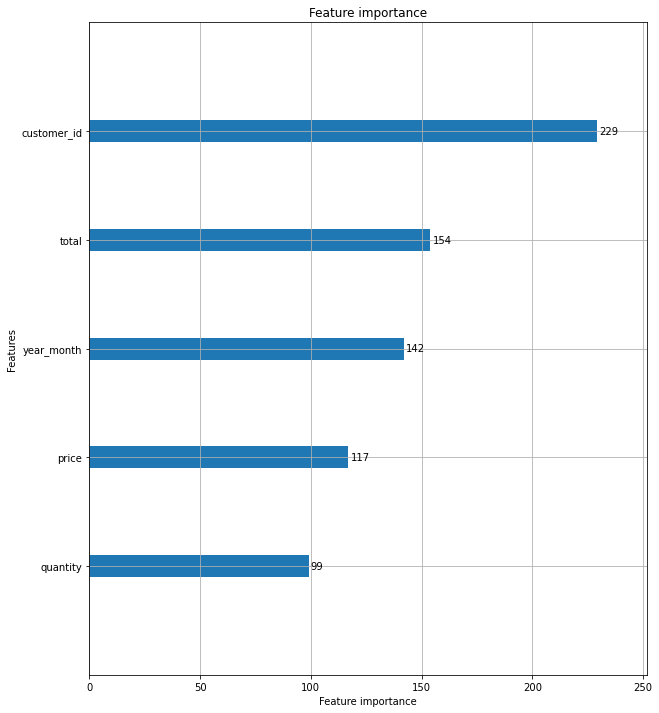

In [56]:
# LightGBM
from lightgbm import LGBMClassifier
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from lightgbm import plot_importance
import matplotlib.pyplot as plt

lgbm_wrapper = LGBMClassifier(n_estimators=400)
evals = [(X_test, y_test)]
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='logloss', eval_set=evals, verbose=True)
pred = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:1]

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(lgbm_wrapper, ax=ax)
plt.show()

In [57]:
# 로지스틱 회귀분석
model=LogisticRegression()
model.fit(X_train, y_train)
score=model.score(X_test, y_test)
print(score)

0.9700561447286338


In [58]:
# KNN 스코어 보기 
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train,y_train)
print('accuracy : {:.2f}'.format(knn.score(X_test,y_test)))

accuracy : 0.98


In [59]:
# 나이브 베이즈
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

#Create a Gaussian Classifier
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

# 나이브 베이즈 스코어 보기 
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9609066333957164


In [60]:
# 하이퍼 파라미터 수정을 통해 모델 정확도 다시 확인 하기

#Overfitting을 막기 위해 트리의 깊이를 줄여 pre-pruning을 강하게 함.
gbc = GradientBoostingClassifier(random_state=0, max_depth=1)

gbc.fit(X_train, y_train)

score_train_pre = gbc.score(X_train, y_train) # train set 정확도
print('{:.3f}'.format(score_train_pre))

score_test_pre = gbc.score(X_test, y_test) # 일반화 정확도
print('{:.3f}'.format(score_test_pre))

# learning_rate를 조절
gbc = GradientBoostingClassifier(random_state=0, max_depth=3, learning_rate=0.01) # 기본값 0.1

gbc.fit(X_train, y_train)

score_train_lr = gbc.score(X_train, y_train)
print('{:.3f}'.format(score_train_lr))

score_test_lr = gbc.score(X_test, y_test) 
print('{:.3f}'.format(score_test_lr))

1.000
1.000
1.000
1.000


In [55]:
# 평가지표 출력 함수 정의
def print_score(label, pred, prob_thres=0.5):
    print('Precision: {:.5f}'.format(precision_score(label, pred>prob_thres)))
    print('Recall: {:.5f}'.format(recall_score(label, pred>prob_thres)))
    print('F1 Score: {:.5f}'.format(f1_score(label, pred>prob_thres)))
    print('ROC AUC Score: {:.5f}'.format(roc_auc_score(label, pred)))